In [497]:
import numpy as np
from sexpdata import loads, dumps, Symbol
from matplotlib import pyplot as plt
from collections import defaultdict
# import igraph
import snap
snap.Version

'6.0.0'

In [459]:
def isArr(x): return isinstance(x, np.ndarray)
def sing(x): return np.array([x])
def unsing(x): return x[0] if len(x) == 1 else x
def isNum(x): return type(x) in (int, float)
def isSym(x): return isinstance(x, Symbol)
def isList(x): return type(x) in (list, tuple) #isinstance(x, list)
def isStr(x): return isinstance(x, str)
def toArr(x): return x if isArr(x) else (np.array(x) if isList(x) else sing(x))

In [476]:
class Agent():
    def __init__(self, i=1, s=8, o=1, M=None):
        self.seti(i)
        self.sets(s)
        self.seto(o)
        self.setM(M)
        
    def seti(self, i=1):
        self.i = i if isArr(i) else np.zeros(i)
        self.si = len(self.i)
    def sets(self, s=8):
        self.s = s if isArr(s) else np.zeros(s)
        self.ss = len(self.s)
    def seto(self, o=1):
        self.o = o if isArr(o) else np.zeros(o)
        self.so = len(self.o)
    def setM(self, M=None):
        self.M = M if isArr(M) else np.zeros((1*(self.si+self.ss+self.so), self.ss+self.so))

    def step(self, *i):
        self.i = toArr(i) #i if isArr(i) else sing(i)
        v = np.concatenate([self.i, self.s, self.o])        # in ++ state ++ out
        w = np.dot(v, self.M)                               # update
        self.s, self.o = w[:-self.so], w[-self.so:]         # state ++ out
        return self.o

    def trace(self, inputs): return [unsing(self.step(i)) for i in inputs]

In [429]:
# ex in: (d (d i))
# ex ir: {((0, 1),): 1, ((0, 1), (1, -1)): 2, ((2, 1),): 3, ((2, 1), (3, -1)): 4}
# ex out: Agent(1, 3, 1, M) with shape(M)==(5,4)
def comp(*exprs):
    so = len(exprs)
    def sym2str(s): return str(s)[8:-2]
    def syms2strs(t): 
        if isSym(t): return sym2str(t)
        elif isList(t): return [syms2strs(ti) for ti in t]
        else: return t

    ts = [syms2strs(loads(e)) for e in exprs]
    
    s = [0]
    def getSI(t):
        if isStr(t):
            if t[0] == 'i': 
                 try: s[0] = max(s[0], int(t[1:]))
                 except: pass
        elif isList(t):
            for ti in t: getSI(ti)
    for t in ts: getSI(t)
    si = s[0]+1
    
    c = [s[0]]
    def newSym():
        c[0] += 1
        return c[0]

    p2s = {}
    def node(*p):
        p = tuple(sorted(p))
        if p not in p2s: p2s[p] = newSym()
        return p2s[p]

    def toMono(t):
        if isList(t) and t[0] == '*' and len(t) == 3: # match t with [*, x, y]
            if isNum(t[1]): return t        # ex: (* 3 i) ~> (* 3 i)
            if isNum(t[2]): 
                return ['*', t[2], t[1]]    # ex: (* i 2) ~> (* 2 i)
        return ['*', 1, t]                  # ex: i       ~> (* 1 i)

    def f(t, fresh=True):
        if isStr(t):
            ret = 0
            if   t == 'i': ret =  0
            elif t == 'o': ret = -1
            elif t == 'r': ret = -2
            elif t[0] == 'i': ret = int(t[1:])
            return node((ret, 1)) if fresh else ret
        elif isList(t):
            if t[0] == 'd':
                x = f(t[1], False)
                xlag = node((x, 1))
                return node((x, 1), (xlag, -1))
            elif t[0] == '+':
                args = map(toMono, t[1:])
                return node(*[(f(a[2], False), a[1]) for a in args])
            elif t[0] == '-':
                args = [toMono(ti) for ti in t[1:]]
                return node((f(args[0][2], False), args[0][1]), *[(f(a[2], False), -a[1]) for a in args[1:]])
                # x, y = f(t[1], False), f(t[2], False)
                # return node((x, 1), (y, -1))
            elif t[0] == 'int':
                x = f(t[1], False)
                return node((x, 1), (-2, 1))    # -2 hacks recursion

    # TODO: handle multiple outputs. this may require permuting the nodes. fix the t=='o' case above.
    ns = [f(t) for t in ts]
    n = ns[-1]

    print(n)
    print(p2s)

    M = np.zeros((n+1, n+1-si))
    for p, s in p2s.items(): 
        # print(s, p)
        for s2, c in p: 
            if s2 == -2: s2 = s # hack recursion
            M[s2][s-si] += c

    return Agent(si, n-1, so, M)


In [483]:
_I, _S, _O = range(3)
class Node():
    def __init__(self, *edges, name=None, layer=None):
        self.edges = [(n or self, w) for (n, w) in edges] or [] # None for self reference TODO: unnecessary?
        self.name = name #or f"N{id(self)}"
        self.layer = layer or (_S if edges else _I)
        self.iden = name or (id(self) if layer==_I else sorted([(id(n), w) for (n, w) in self.edges]))
    def __eq__(self, other): return isinstance(other, Node) and self.iden == other.iden
    def __hash__(self): return hash(self.iden)
    def __iadd__(self, other):  # update with new nodes, self.iden shouldn't change, TODO: THIS DOESN"T WORK AT ALL
        # the problem is that a node can start with either a name or edges and acquire the other later
        self.edges = self.edges or other.edges
        self.name = self.name or other.name
        self.layer = max(self.layer, other.layer)

class Graph():
    def __init__(self): self.nodes = {}
    def add(self, node):
        if node in self.nodes: self.nodes[node] += node
        else: self.nodes[node] = node
        return self.nodes[node]
    def mk(self, *args): return self.add(Node(*args))


In [ ]:
# ex in: (d (d i))
# ex ir: {((0, 1),): 1, ((0, 1), (1, -1)): 2, ((2, 1),): 3, ((2, 1), (3, -1)): 4}
# ex out: Agent(1, 3, 1, M) with shape(M)==(5,4)
def comp2(*exprs):
    so = len(exprs)
    def sym2str(s): return str(s)[8:-2]
    def syms2strs(t): 
        if isSym(t): return sym2str(t)
        elif isList(t): return [syms2strs(ti) for ti in t]
        else: return t

    ts = [syms2strs(loads(e)) for e in exprs]

    G = Graph()

    def toMono(t):
        if isList(t) and t[0] == '*' and len(t) == 3: # match t with [*, x, y]
            if isNum(t[1]): return t        # ex: (* 3 i) ~> (* 3 i)
            if isNum(t[2]): 
                return ['*', t[2], t[1]]    # ex: (* i 2) ~> (* 2 i)
        return ['*', 1, t]                  # ex: i       ~> (* 1 i)

    def f(t):
        if isStr(t):
            if   t[0] == 'i': return G.mk(name=t)
            elif t[0] == 'o': return G.mk(name=t)
            elif t == 'r': return _R
            raise f"BAD SYMBOL: {t}"
        elif isList(t):
            if t[0] == 'd':
                n = f(t[1])
                nlag = G.mk((n, 1))
                return G.mk((n, 1), (nlag, -1))
            elif t[0] == '+':
                args = map(toMono, t[1:])
                return node(*[(f(a[2], False), a[1]) for a in args])    # TODO: left off here
            elif t[0] == '-':
                args = [toMono(ti) for ti in t[1:]]
                return node((f(args[0][2], False), args[0][1]), *[(f(a[2], False), -a[1]) for a in args[1:]])
                # x, y = f(t[1], False), f(t[2], False)
                # return node((x, 1), (y, -1))
            elif t[0] == 'int':
                x = f(t[1], False)
                return node((x, 1), (-2, 1))    # -2 hacks recursion

In [ ]:
# class Node():
#     def __init__(self, name=None, layer=None):
#         self.name = name
#         self.layer = layer or (_S if name else _I)
#         self.iden = self.name or id(self)
#     def __eq__(self, other): return self is other # isinstance(other, Node) and self.iden == other.iden
#     def __hash__(self): return hash(self.iden)
#     def __iadd__(self, other):
#         self.name = self.name or other.name
#         self.layer = max(self.layer, other.layer)
#         self.iden = self.iden or id(self)
#     def __add__(self, other): return Node(self.name or other.name, max(self.layer, other.layer))

# class Partition():
#     def __init__(self): self.parent = {}
#     def union(self, i, j):
#         si = self.find(si)
#         sj = self.find(sj)
#         self.parent[si] = sj
#     def find(self, i):
#         if i in self.parent:
#             s = self.find(self.parent[i])
#             self.parent[i] = s
#             return s
#         return i

In [506]:
_I, _S, _O = range(1, 4)

class Graph():
    def __init__(self): 
        self.g = snap.TNGraph.New()     # a directed non-multi graph
        self.name = {}                  # str -> int
        self.layer = {}                 # int -> _I | _S | _O
        self.weight = {}                # (int, int) -> weight
        self.c = 0                      # counter for fresh ids
    def fresh(self):
        self.c += 1
        return self.c
    def node(self, name=None, layer=None):
        i = self.fresh()
        self.g.AddNode(i)
        if name: self.names[name] = i
        self.layer[i] = layer or (_S if name else _I)
        return i
    def edge(self, i, j, w): 
        self.g.AddEdge(i, j)
        self.weight[i, j] = w
    def mk(self, *lc, **kwargs):
        i = self.node(**kwargs)
        for (j, w) in lc: self.edge(i, j or i, w)   # FIXME: could be quadratic
        # test: print out edges
        # for j in self.g.GetNI(i).GetOutEdges():
            # print(f"{i} -{self.weight[i,j]}-> {j}")
        self.merge(i)
        return i
    def merge(self, x=None, y=None):
        if y: pass      # TODO: merge x and y
            # ins = g.
        elif x: pass    # TODO: try to find y to merge
            # intersect([p in pred(s) if edges[p, s] == edges[x, s]] for s in succs(x))
            # then select only those with the same number of succs as x
            # merge(x, p) all of those
        else: pass      # TODO: try all x's
    
    # TODO: keep track of name->node mapping?
    # TODO: just collapse nodes afterwards? support merging as primitive graph operation
    # TODO: ^ I think we can just be smart and collapse as we go, w/o needing memo

g = Graph()
i0 = g.mk()
i1 = g.mk()
i2 = g.mk((i0, 0.3), (i1, 0.7))
# print(i0, i1)

In [491]:
def comp3(*exprs):
    so = len(exprs)
    def sym2str(s): return str(s)[8:-2]
    def syms2strs(t): 
        if isSym(t): return sym2str(t)
        elif isList(t): return [syms2strs(ti) for ti in t]
        else: return t

    ts = [syms2strs(loads(e)) for e in exprs]

    def toMono(t):
        if isList(t) and t[0] == '*' and len(t) == 3: # match t with [*, x, y]
            if isNum(t[1]): return t        # ex: (* 3 i) ~> (* 3 i)
            if isNum(t[2]): 
                return ['*', t[2], t[1]]    # ex: (* i 2) ~> (* 2 i)
        return ['*', 1, t]                  # ex: i       ~> (* 1 i)

    G = Graph()
    
    def f(t):
        if isStr(t):
            if   t[0] == 'i': return G.mk(name=t)
            elif t[0] == 'o': return G.mk(name=t)
            elif t == 'r': return _R
            raise f"BAD SYMBOL: {t}"
        elif isList(t):
            if t[0] == 'd':
                n = f(t[1])
                nlag = G.mk((n, 1))
                return G.mk((n, 1), (nlag, -1))
            elif t[0] == '+':
                args = map(toMono, t[1:])
                return node(*[(f(a[2], False), a[1]) for a in args])    # TODO: left off here
            elif t[0] == '-':
                args = [toMono(ti) for ti in t[1:]]
                return node((f(args[0][2], False), args[0][1]), *[(f(a[2], False), -a[1]) for a in args[1:]])
                # x, y = f(t[1], False), f(t[2], False)
                # return node((x, 1), (y, -1))
            elif t[0] == 'int':
                x = f(t[1], False)
                return node((x, 1), (-2, 1))    # -2 hacks recursion

In [494]:
g = Graph()
x, y = Node("i0", _I), Node("o0", _O)
g.add_vertices(x, y)
g.add_edges([(x, y)])


TypeError: an integer is required (got type Node)

In [477]:
# #              s0  s1  o             
# M = np.array([[1,  0,  0.5],    # i
#               [0,  1, -1.0],    # s0
#               [0,  0,  0.5],    # s1
#               [0,  0,  0],])    # o
# a = Agent(1, 2, 1, M)

# #              s0  s1  s2  o             
# N = np.array([[1,  1,  0,  0],    # i
#               [0, -1,  0,  0],    # s0
#               [0,  0,  1,  1],    # s1
#               [0,  0,  0, -1],    # s2
#               [0,  0,  0,  0],])  # o

# a = comp("(d (d (d i)))")   # third derivative
# a = comp("(+ (d (d i)) i)")
# a = comp("(+ (d (d (d i))) o o)")

# a = comp("(int (d i))")
# a = comp("(+ (d i) o)")
a = comp("(+ (- i (+ i)) o)")

print(a.M)
inputs = [x*x for x in range(1,10)]
print(inputs)
a.trace(inputs)

3
{((0, 1),): 1, ((0, 1), (1, -1)): 2, ((-1, 1), (2, 1)): 3}
[[ 1.  1.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
[1, 4, 9, 16, 25, 36, 49, 64, 81]


[0.0, 1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0]

4
{((-2, 1), (0, 1)): 1, ((0, 1),): 2, ((0, 1), (2, -1)): 3, ((0, 0.6), (1, 0.2), (3, 0.1)): 4}
[[ 1.   1.   1.   0.6]
 [ 1.   0.   0.   0.2]
 [ 0.   0.  -1.   0. ]
 [ 0.   0.   0.   0.1]
 [ 0.   0.   0.   0. ]]


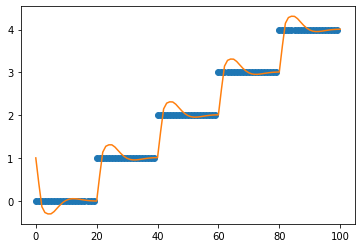

In [479]:
# i: the error
# o: the adjustment
a = comp("""(+  (* 0.6      i) 
                (* 0.2 (int i)) 
                (* 0.1   (d i)) )""")
print(a.M)
L = []
def store(x):
    # print(f"x: {x}")
    L.append(x)

# TODO: implement environment in PID example as it's own agent
x = 1
store(x)
targets = [i//20 for i in range(100)]
for target in targets:
    x += unsing(a.step(target-x)) # target-x is the error
    store(x)

plt.plot(targets, 'o')
plt.plot(L)

In [419]:
a = comp("(+ i0 (* i1 2) i2 r)")
print(a.M)

3
{((-2, 1), (0, 1), (1, 2), (2, 1)): 3}
[[1.]
 [2.]
 [1.]
 [1.]]


5
{((-1, 1),): 1, ((-1, 1), (1, -1)): 2, ((2, 1),): 3, ((2, 1), (3, -1)): 4, ((-1, 1), (0, -1), (4, -0.1)): 5}
4
[[ 0.   0.   0.   0.  -1. ]
 [ 0.  -1.   0.   0.   0. ]
 [ 0.   0.   1.   1.   0. ]
 [ 0.   0.   0.  -1.   0. ]
 [ 0.   0.   0.   0.  -0.1]
 [ 1.   1.   0.   0.   1. ]]


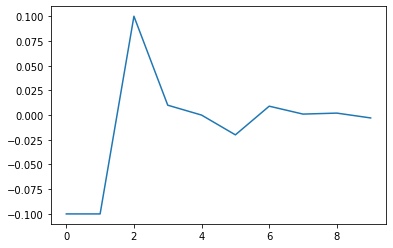

In [446]:
agent = comp("""(+  (* 0.6      (- i0 i1)) 
                    (* 0.2 (int (- i0 i1))) 
                    (* 0.1   (d (- i0 i1))) )""")
env = comp("(+ i o)")
# ctrl = comp("(- o (d (d o)))")

L = []
for n in range(10):
    target = n//20
    dx = agent.step(target, )
    L.append(ctrl.step(0))

plt.plot(L)


In [432]:
comp("(- (* 0.5 o) i)").M

1
{((-1, 0.5), (0, -1)): 1}


array([[-1. ],
       [ 0.5]])